In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
import datetime
from scipy import signal
import os
from misc_functions import yearsago
import calendar
from dateutil.relativedelta import relativedelta
from scipy import fftpack

cwd = os.getcwd()

%matplotlib inline

In [39]:
subject = "stat"
if not os.path.exists(f"{cwd}/plots/{subject}"):
    os.mkdir(f"{cwd}/plots/{subject}")


with open(f"{cwd}/data/{subject}/date_list.pkl", "rb") as f:
    date_list = pickle.load(f)
datetime_list = [datetime.datetime.combine(d, datetime.time.min) for d in date_list]
datetime_list = sorted(datetime_list)

dcounts = Counter(d for d in datetime_list)
date_list, count_list = [], []
for d, count in dcounts.items():
    date_list.append(d)
    count_list.append(count)

#Monday is 0 and Sunday is 6
day_of_week_list = [d.weekday() for d in date_list]

#Grouping by day of the week
slice_indx_lst = []
old_day_indx = -1 #Throwaway negative number
for i, day_indx in enumerate(day_of_week_list):
    if old_day_indx >= day_indx:
        slice_indx_lst.append(i)
    old_day_indx = day_indx
slice_indx_lst.append(len(date_list))
slice_indx_lst.insert(0, 0)
sliced_days, sliced_dates, sliced_counts = [], [], []
for i, j in zip(slice_indx_lst[:-1], slice_indx_lst[1:]):
    sliced_days.append(day_of_week_list[i:j])
    sliced_dates.append(date_list[i:j])
    sliced_counts.append(count_list[i:j])


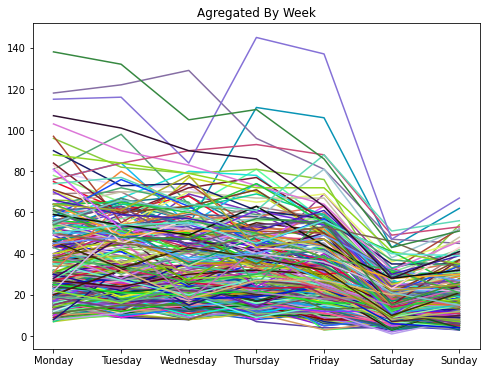

In [40]:
fig, ax = plt.subplots(figsize=(8,6))
for days, counts in zip(sliced_days, sliced_counts):

    #Inserting zeros anytime there is a blank entry and changing blank entry to contain consecutive day
    ax.plot(days, counts, c=np.random.rand(3,))

ax.set_xticklabels([' ', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title("Agregated By Week")
plt.savefig(f"{cwd}/plots/{subject}/Agregated_By_Week.pdf")


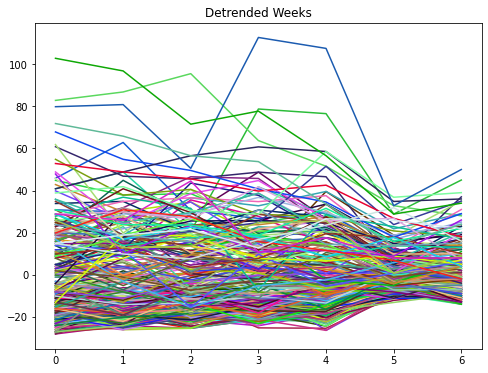

In [41]:
fig, ax = plt.subplots(figsize=(8,6))

all_day_list = [0, 1, 2, 3, 4, 5, 6]
all_day_count = [0, 0, 0, 0, 0, 0, 0] 
for days, counts in zip(sliced_days, sliced_counts):
    for day, count in zip(days, counts):
        all_day_count[day] += count

all_day_count = [i / len(sliced_counts) for i in all_day_count]

detrended_sliced_counts = []
for days, counts in zip(sliced_days, sliced_counts):
    new_count_list = []
    for day, count in zip(days, counts):
        new_count = count - all_day_count[day]
        new_count_list.append(new_count)
    detrended_sliced_counts.append(new_count_list)

for days, counts in zip(sliced_days, detrended_sliced_counts):
    ax.plot(days, counts, c=np.random.rand(3,))

plt.title("Detrended Weeks")
plt.savefig(f"{cwd}/plots/{subject}/Detrended_Agregated_By_Week.pdf")

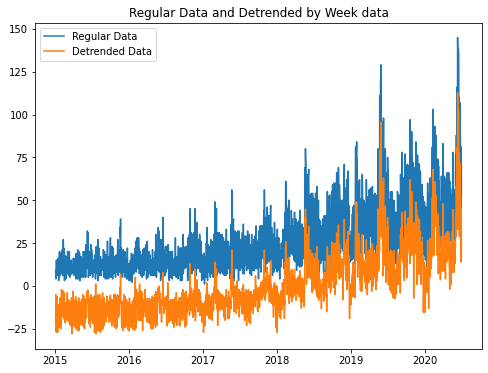

In [42]:
fig, ax = plt.subplots(figsize=(8,6))
detrended_count_list = [item for sublist in detrended_sliced_counts for item in sublist]
ax.plot(date_list, count_list, label='Regular Data')
ax.plot(date_list, detrended_count_list, label='Detrended Data')
plt.legend()

plt.title("Regular Data and Detrended by Week data")
plt.savefig(f"{cwd}/plots/{subject}/Full_Data.pdf")

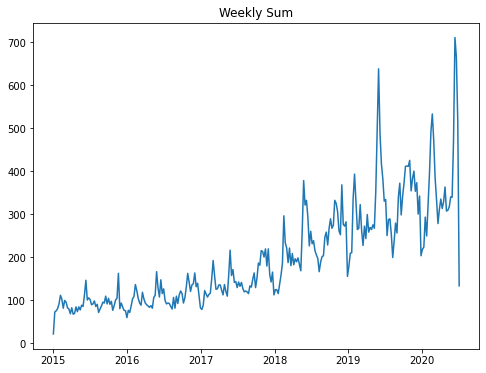

In [43]:
#weekly sums
fig, ax = plt.subplots(figsize=(8,6))
sumed_week_list = [sum(sliced) for sliced in sliced_counts]
num_weeks = [date_list[0] +  datetime.timedelta(weeks=i) for i in range(len(sliced_counts))]
ax.plot(num_weeks, sumed_week_list)
plt.title("Weekly Sum")
plt.savefig(f"{cwd}/plots/{subject}/Summed_By_Week.pdf")


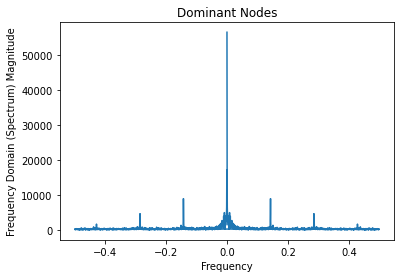

In [44]:
#Computing discrete fourier transform
fig, ax = plt.subplots()

X = fftpack.fft(count_list)
freqs = fftpack.fftfreq(len(count_list))

ax.set_xlabel('Frequency')
ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
ax.plot(freqs, np.abs(X))

plt.title("Dominant Nodes")
plt.savefig(f"{cwd}/plots/{subject}/Dominant_Nodes.pdf")

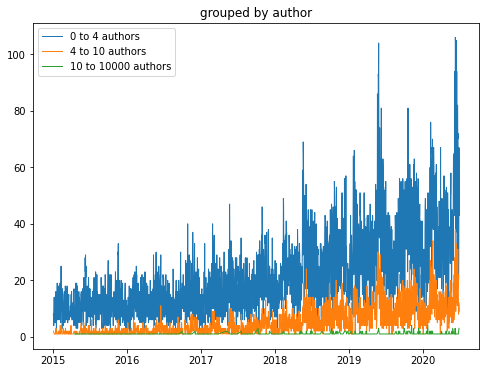

In [45]:
with open(f"{cwd}/data/{subject}/date_list.pkl", "rb") as f:
    date_list = pickle.load(f)
with open(f"{cwd}/data/{subject}/author_length_list.pkl", "rb") as f:
    num_authors_list = pickle.load(f)
    
datetime_list = [datetime.datetime.combine(d, datetime.time.min) for d in date_list]
datetime_list, num_authors_list = zip(*sorted(zip(datetime_list, num_authors_list)))

#Finding indexs where in each range
author_ranges = [(0, 4), (4, 10), (10, 10000)]
range_idxs = [[] for i in range(len(author_ranges))]
for idx, num_authors in enumerate(num_authors_list):
    for i, rng in enumerate(author_ranges):
        if rng[0] < num_authors <= rng[1]:
            range_idxs[i].append(idx)

datetime_grouped_list = [[datetime_list[j] for j in range_idxs[i]] for i in range(len(author_ranges))]

fig, ax = plt.subplots(figsize=(8,6))
for rng, datetime_list in zip(author_ranges, datetime_grouped_list):            
    dcounts = Counter(d for d in datetime_list)
    date_list, count_list = [], []
    for d, count in dcounts.items():
        date_list.append(d)
        count_list.append(count)
    ax.plot(date_list, count_list, linewidth=1, label=f"{rng[0]} to {rng[1]} authors")
    
plt.title("grouped by author")
plt.savefig(f"{cwd}/plots/{subject}/grouped_by_author.pdf")
plt.legend()

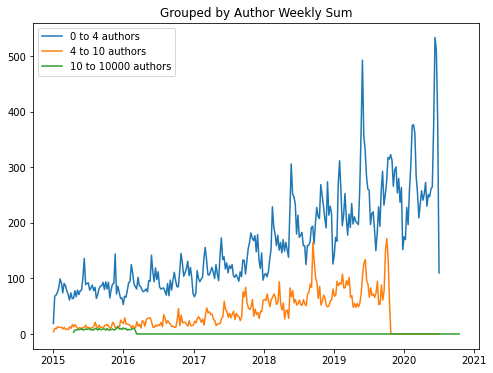

In [46]:
with open(f"{cwd}/data/{subject}/date_list.pkl", "rb") as f:
    date_list = pickle.load(f)
with open(f"{cwd}/data/{subject}/author_length_list.pkl", "rb") as f:
    num_authors_list = pickle.load(f)
    
datetime_list = [datetime.datetime.combine(d, datetime.time.min) for d in date_list]
datetime_list, num_authors_list = zip(*sorted(zip(datetime_list, num_authors_list)))

#Finding indexs where in each range
author_ranges = [(0, 4), (4, 10), (10, 10000)]
range_idxs = [[] for i in range(len(author_ranges))]
for idx, num_authors in enumerate(num_authors_list):
    for i, rng in enumerate(author_ranges):
        if rng[0] < num_authors <= rng[1]:
            range_idxs[i].append(idx)

datetime_grouped_list = [[datetime_list[j] for j in range_idxs[i]] for i in range(len(author_ranges))]

fig, ax = plt.subplots(figsize=(8,6))
for rng, datetime_list in zip(author_ranges, datetime_grouped_list):            
    dcounts = Counter(d for d in datetime_list)
    date_list, count_list = [], []
    for d, count in dcounts.items():
        date_list.append(d)
        count_list.append(count)
        
    #Grouping by day of the week
    slice_indx_lst = []
    old_day_indx = -1 #Throwaway negative number
    for i, day_indx in enumerate(day_of_week_list):
        if old_day_indx >= day_indx:
            slice_indx_lst.append(i)
        old_day_indx = day_indx
    slice_indx_lst.append(len(date_list))
    slice_indx_lst.insert(0, 0)
    sliced_days, sliced_dates, sliced_counts = [], [], []
    for i, j in zip(slice_indx_lst[:-1], slice_indx_lst[1:]):
        sliced_days.append(day_of_week_list[i:j])
        sliced_dates.append(date_list[i:j])
        sliced_counts.append(count_list[i:j])
        
    sumed_week_list = [sum(sliced) for sliced in sliced_counts]
    num_weeks = [date_list[0] +  datetime.timedelta(weeks=i) for i in range(len(sliced_counts))]
        
        
        
    ax.plot(num_weeks, sumed_week_list, label=f"{rng[0]} to {rng[1]} authors")

plt.title("Grouped by Author Weekly Sum")
plt.savefig(f"{cwd}/plots/{subject}/grouped_by_author_weekly_sum.pdf")
plt.legend()

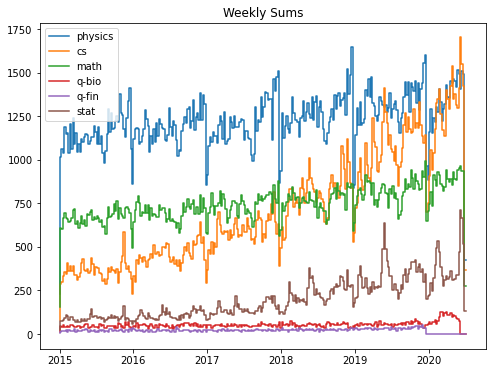

In [47]:
#Plotting all weekly sum Data toghehter
subject_list = ['physics', 'cs', 'math', 'q-bio', 'q-fin', 'stat']
fig, ax = plt.subplots(figsize=(8,6))
for subject in subject_list:
    with open(f"{cwd}/data/{subject}/date_list.pkl", "rb") as f:
        date_list = pickle.load(f)
        datetime_list = [datetime.datetime.combine(d, datetime.time.min) for d in date_list]
        datetime_list = sorted(datetime_list)

        dcounts = Counter(d for d in datetime_list)
        date_list, count_list = [], []
        for d, count in dcounts.items():
            date_list.append(d)
            count_list.append(count)
            
            
        #Grouping by day of the week
        slice_indx_lst = []
        old_day_indx = -1 #Throwaway negative number
        for i, day_indx in enumerate(day_of_week_list):
            if old_day_indx >= day_indx:
                slice_indx_lst.append(i)
            old_day_indx = day_indx
        slice_indx_lst.append(len(date_list))
        slice_indx_lst.insert(0, 0)
        sliced_days, sliced_dates, sliced_counts = [], [], []
        for i, j in zip(slice_indx_lst[:-1], slice_indx_lst[1:]):
            sliced_days.append(day_of_week_list[i:j])
            sliced_dates.append(date_list[i:j])
            sliced_counts.append(count_list[i:j])
        
        sumed_week_list = [sum(sliced) for sliced in sliced_counts]
        num_weeks = [date_list[0] +  datetime.timedelta(weeks=i) for i in range(len(sliced_counts))]
        ax.step(num_weeks, sumed_week_list, label=subject)

plt.legend()
if not os.path.exists(f"{cwd}/plots/misc"):
    os.mkdir(f"{cwd}/plots/misc/")
plt.title("Weekly Sums")
plt.savefig(f"{cwd}/plots/misc/weekly_sum.pdf")
        
            

[5828, 6067, 6254, 6333] 66
[5828, 6067, 6254, 6333] 66
[5407, 5990, 5815, 6452] 66
[5407, 5990, 5815, 6452] 66
[3844, 3804, 3916, 4054] 66
[3844, 3804, 3916, 4054] 66
[382, 506, 474, 393] 66
[382, 506, 474, 393] 66
[1468, 1442, 1382, 2496] 66
[1468, 1442, 1382, 2496] 66


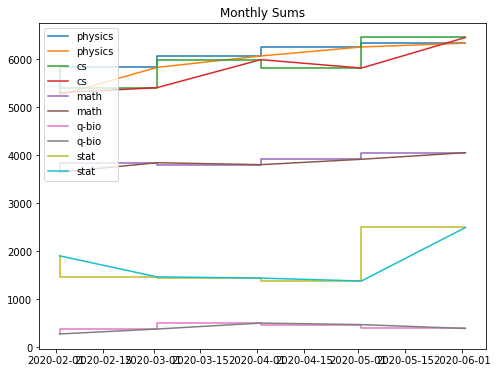

In [48]:
#Plotting all weekly sum Data toghehter
def add_months(sourcedate, months):
    """ see https://stackoverflow.com/questions/4130922/how-to-increment
    -datetime-by-custom-months-in-python-without-using-library """
    month = sourcedate.month - 1 + months
    year = sourcedate.year + month // 12
    month = month % 12 + 1
    day = min(sourcedate.day, calendar.monthrange(year,month)[1])
    return datetime.date(year, month, day)


subject_list = ['physics', 'cs', 'math', 'q-bio', 'stat']
fig, ax = plt.subplots(figsize=(8,6))
for subject in subject_list:
    with open(f"{cwd}/data/{subject}/date_list.pkl", "rb") as f:
        date_list = pickle.load(f)
    datetime_list = [datetime.datetime.combine(d, datetime.time.min) for d in date_list]
    datetime_list = sorted(datetime_list)

    dcounts = Counter(d for d in datetime_list)
    date_list, count_list = [], []
    for d, count in dcounts.items():
        date_list.append(d)
        count_list.append(count)

    #Summing by month
    slice_indx_lst = []
    old_month = -1 #Throwaway value
    for i, date in enumerate(date_list):
        if date.month != old_month:
            old_month = date.month
            slice_indx_lst.append(i)
    slice_indx_lst.append(len(date_list))
    sliced_days, sliced_dates, sliced_counts = [], [], []
    for i, j in zip(slice_indx_lst[:-1], slice_indx_lst[1:]):
        sliced_dates.append(date_list[i:j])
        sliced_counts.append(count_list[i:j])

    sumed_month_list = [sum(sliced) for sliced in sliced_counts]
    print(sumed_month_list[-4:], len(sumed_month_list))
    #sumed_month_list.insert(0, sumed_month_list[0])
    print(sumed_month_list[-4:], len(sumed_month_list))
    num_months = [add_months(date_list[0], i) for i in range(len(sliced_counts))] #Adding dummy last value
    #num_months.insert(0, datetime.datetime(year = num_months[0].year - 1, month=12, day=1))
    ax.step(num_months[-5:], sumed_month_list[-5:], label=subject)
    ax.plot(num_months[-5:], sumed_month_list[-5:], label=subject)

plt.legend(loc='upper left')
if not os.path.exists(f"{cwd}/plots/misc"):
    os.mkdir(f"{cwd}/plots/misc/")
plt.title("Monthly Sums")
plt.savefig(f"{cwd}/plots/misc/monthly_sum.pdf")



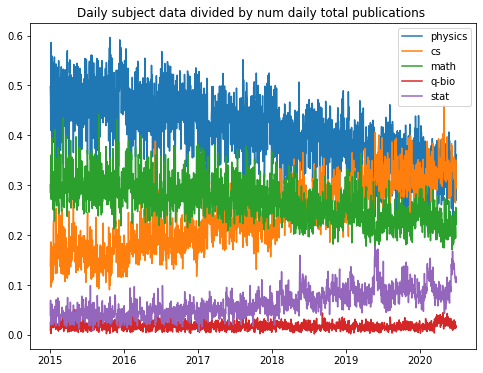

In [49]:
#Gettings total number of counts for each date
subject_list = ['physics', 'cs', 'math', 'q-bio', 'stat']
datetime_list = []
for subject in subject_list:
    with open(f"{cwd}/data/{subject}/date_list.pkl", "rb") as f:
        tmp_date_list = pickle.load(f)
    tmp_datetime_list = [datetime.datetime.combine(d, datetime.time.min) for d in tmp_date_list]
    tmp_datetime_list = sorted(tmp_datetime_list)
    datetime_list.extend(tmp_datetime_list)

dcounts = Counter(d for d in datetime_list)
total_date_list, total_count_list = [], []
for d, count in dcounts.items():
    total_date_list.append(d)
    total_count_list.append(count)
    
#Plotting all weekly sum Data toghehter
subject_list = ['physics', 'cs', 'math', 'q-bio', 'stat']
fig, ax = plt.subplots(figsize=(8,6))
for subject in subject_list:
    
    #Getting the total number of publications for that day
    
    with open(f"{cwd}/data/{subject}/date_list.pkl", "rb") as f:
        date_list = pickle.load(f)
        datetime_list = [datetime.datetime.combine(d, datetime.time.min) for d in date_list]
        datetime_list = sorted(datetime_list)

        dcounts = Counter(d for d in datetime_list)
        date_list, count_list = [], []
        for d, count in dcounts.items():
            date_list.append(d)
            total_count = total_count_list[total_date_list.index(d)]
            count_list.append(count/total_count)

    ax.plot(date_list, count_list, label=subject)
plt.title("Daily subject data divided by num daily total publications ")
plt.savefig(f"{cwd}/plots/misc/daily_data_normalized.pdf")
plt.legend()